In [1]:
import numpy as np
import pandas as pd
pdidx = pd.IndexSlice
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import colors as mcolors
import matplotlib.patches as mpatches
import matplotlib.cm as cm
from numpy import random as rand
from scipy import *
import time as T
import gtda
import plotly
from plotly.offline import init_notebook_mode, iplot
from plotly.graph_objs import *
init_notebook_mode(connected=True)
from gtda.plotting import plot_point_cloud
from gtda.plotting import plot_diagram
from sklearn.metrics import roc_curve, roc_auc_score, log_loss, accuracy_score, precision_recall_curve,\
                            average_precision_score, brier_score_loss
from sklearn.calibration import calibration_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
import xgboost as xgb
from xgboost import XGBRegressor

# Testing correlations

In [2]:
path_to_data = "../train.csv"
ALL_DATA = pd.read_csv(path_to_data)

In [3]:
def preprocess_PoC(df):
       
#     df = df.drop(columns=['near_price','far_price']).dropna()

    df = (df
          .set_index(['date_id','stock_id','seconds_in_bucket'])
          .sort_index(level=['date_id','stock_id','seconds_in_bucket'], sort_remaining=False))
    
    # Drop row_id and time_id, not needed for training
    df = df.drop(['row_id', 'time_id'], axis=1)
    # And, in this case, we select every 10th of each time series input
    targets = df[['target']]#.loc[pd.IndexSlice[:, :, ::10]]
    df = df.drop(['target'], axis=1)
    
    return df, targets

In [4]:
X_processed, y_processed = preprocess_PoC(ALL_DATA)
%reset_selective ALL_ASSETS

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [5]:
x_wide = X_processed.unstack('stock_id')
# x_wide

In [6]:
y_wide = y_processed['target'].unstack('stock_id')

## Target with Target

In [ ]:
cmap = 'RdBu_r'
# maybe should do target with next time step target? although i guess that should
# go linearly with target - target change correlation
# ...
# they seem to be surprisngly different, did i do something wrong?
# probably not, see markdown below for interpretation

y_forward = y_wide.groupby(level='date_id').shift(-1)
for dt in y_wide.index.get_level_values('seconds_in_bucket').unique()[::4]:
    subdf = y_wide.loc[pdidx[:, dt], :]
    subdf_forward = y_forward.loc[pdidx[:, dt], :]
    cat = pd.concat([subdf, subdf_forward], axis=1, keys=['now', 'future'])
    # Calculate correlation
    corr_matrix = cat.corr().loc['now', 'future']
    
    f = plt.figure(figsize=(9, 9))
    
    # CRITICAL: Set vmin and vmax to fix the color scale
    im = plt.matshow(corr_matrix, fignum=f.number, cmap=cmap, vmin=-0.6, vmax=0.6)
    
    # Fix the tick logic to use y_slice since subdf isn't defined here
    num_stocks = subdf.shape[1]
    plt.xticks(range(0, num_stocks, 10), subdf.columns[::10], fontsize=14, rotation=45)
    plt.yticks(range(0, num_stocks, 10), subdf.columns[::10], fontsize=14)
    
    # The colorbar will now represent the same -1 to 1 range for every plot
    cb = plt.colorbar(im, fraction=0.046, pad=0.04)
    cb.ax.tick_params(labelsize=14)
    
    plt.title(f'Correlation Matrix at time {dt}\nTarget with Target', fontsize=16, pad=20)
    plt.show()

## Target changes with Target changes

In [ ]:
# now corrected to forward difference
DY = y_wide - y_wide.groupby(level='date_id').shift(1)
cmap = 'RdBu_r'

for dt in DY.index.get_level_values('seconds_in_bucket').unique()[::4]:
    subdf_T = y_wide.loc[pdidx[:, dt], :]
    subdf_dT = DY.loc[pdidx[:, dt], :]
    # Calculate correlation
    cat = pd.concat([subdf_T, subdf_dT], axis=1, keys=['target', 'target_ch'])
    corr_matrix = cat.corr().loc['target', 'target_ch']
    
    f = plt.figure(figsize=(9, 9))
    
    # CRITICAL: Set vmin and vmax to fix the color scale
    im = plt.matshow(corr_matrix, fignum=f.number, cmap=cmap, vmin=-0.6, vmax=0.6)
    
    # Fix the tick logic to use y_slice since subdf isn't defined here
    num_stocks = DY.shape[1]
    plt.xticks(range(0, num_stocks, 10), DY.columns[::10], fontsize=14, rotation=45)
    plt.yticks(range(0, num_stocks, 10), DY.columns[::10], fontsize=14)
    
    # The colorbar will now represent the same -1 to 1 range for every plot
    cb = plt.colorbar(im, fraction=0.046, pad=0.04)
    cb.ax.tick_params(labelsize=14)
    
    plt.title(f'Correlation Matrix at time {dt}\nTarget with Target Changes', fontsize=16, pad=20)
    plt.show()

## Comparing target - target forward correlations with target - target change correlations, it seems we see that (now after correcting for peak-forwards):
1) Both Target and Target Changes are positively correlated with itself

## Features with Target

In [ ]:
x_wide.stack().columns.unique()

In [ ]:
feature = 'wap'
# we shouldn't look at time 0 for wap because the correlation is undefined since everything is 1 anyway
wapSwitch = 0  

In [ ]:
cmap = 'RdBu_r'
y_forward = y_wide.groupby(level='date_id').shift(-1)
for dt in y_wide.index.get_level_values('seconds_in_bucket').unique()[wapSwitch::4]:
    y_slice = y_forward.loc[pdidx[:, dt], :]
    x_slice = x_wide.loc[pdidx[:, dt], feature]
#     print(x_slice)
    cat = pd.concat([x_slice, y_slice], axis=1, keys=['X', 'target'])
    
    # Calculate correlation
    corr_matrix = cat.corr().loc['X', 'target']
    
    f = plt.figure(figsize=(9, 9))
    
    # CRITICAL: Set vmin and vmax to fix the color scale
    im = plt.matshow(corr_matrix, fignum=f.number, cmap=cmap, vmin=-0.4, vmax=0.4)
    
    # Fix the tick logic to use y_slice since subdf isn't defined here
    num_stocks = y_slice.shape[1]
    plt.xticks(range(0, num_stocks, 10), y_slice.columns[::10], fontsize=14, rotation=45)
    plt.yticks(range(0, num_stocks, 10), y_slice.columns[::10], fontsize=14)
    
    # The colorbar will now represent the same -1 to 1 range for every plot
    cb = plt.colorbar(im, fraction=0.046, pad=0.04)
    cb.ax.tick_params(labelsize=14)
    
    plt.title(f'Correlation Matrix at time {dt}\nFeature: {feature}', fontsize=16, pad=20)
    plt.show()

## Features with Target changes

In [ ]:
cmap = 'RdBu_r'
for dt in y_wide.index.get_level_values('seconds_in_bucket').unique()[wapSwitch::4]:
    DY_slice = DY.loc[pdidx[:, dt], :]
    x_slice = x_wide.loc[pdidx[:, dt], feature]
    cat = pd.concat([x_slice, DY_slice], axis=1, keys=['X', 'target'])
    
    # Calculate correlation
    corr_matrix = cat.corr().loc['X', 'target']
    
    f = plt.figure(figsize=(9, 9))
    
    # CRITICAL: Set vmin and vmax to fix the color scale
    im = plt.matshow(corr_matrix, fignum=f.number, cmap=cmap, vmin=-0.4, vmax=0.4)
    
    # Fix the tick logic to use y_slice since subdf isn't defined here
    num_stocks = DY_slice.shape[1]
    plt.xticks(range(0, num_stocks, 10), DY_slice.columns[::10], fontsize=14, rotation=45)
    plt.yticks(range(0, num_stocks, 10), DY_slice.columns[::10], fontsize=14)
    
    # The colorbar will now represent the same -1 to 1 range for every plot
    cb = plt.colorbar(im, fraction=0.046, pad=0.04)
    cb.ax.tick_params(labelsize=14)
    
    plt.title(f'Correlation Matrix at time {dt}\nFeature: {feature} with Target Changes', fontsize=16, pad=20)
    plt.show()

# Predicitng next Target change direction

## One stock's target, one stock's feature

In [110]:
## pick a stock, say...
STOCK = 145
# we'll try xgboost
# but first, let's create the data we'll need and take a looksie
#wait this actually looks into the future apparently
# DY = y_wide.groupby(level='date_id').shift(-1) - y_wide

#instead let's try
DY = y_wide - y_wide.groupby(level='date_id').shift(1)

In [ ]:
# %matplotlib notebook
full_test_data_X = x_wide.loc[pdidx[:, 520], :].xs(STOCK, level=1, axis=1)
test_data_Y = np.sign(DY.loc[pdidx[:, 520],STOCK])

up_y = test_data_Y[test_data_Y==1]
up_x = full_test_data_X.loc[up_y.index,:]
dwn_y = test_data_Y[test_data_Y==-1]
dwn_x = full_test_data_X.loc[dwn_y.index,:]

feat1 = 'near_price'
feat2 = 'far_price'
feat3 = 'imbalance_buy_sell_flag'

# x_d = dwn_x[feat1]
# if wap is an "average coordinate", below is a "relative coordinate"
x_d = (dwn_x['bid_price']*dwn_x['ask_size'] - dwn_x['ask_price']*dwn_x['bid_size'])/(dwn_x['bid_size']+dwn_x['ask_size'])
y_d = dwn_x[feat2]
z_d = dwn_x[feat3]

# x_nd = up_x[feat1]
x_nd = (up_x['bid_price']*up_x['ask_size'] - up_x['ask_price']*up_x['bid_size'])/(up_x['bid_size']+up_x['ask_size'])
y_nd = up_x[feat2]
z_nd = up_x[feat3]

fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(projection='3d')

ax.scatter(x_nd, y_nd, z_nd, label='went up' ,color='g')#,alpha=.1)
ax.scatter(x_d, y_d, z_d, label='went down',color='r')#,alpha=.5)

ax.legend(bbox_to_anchor=(1, 0.5), loc='upper left', frameon=False)
plt.show()

In [ ]:
%matplotlib

### seems like the relative coordiante is important

In [8]:
# relative wap construction
bid_p = x_wide['bid_price']
ask_p = x_wide['ask_price']
bid_s = x_wide['bid_size']
ask_s = x_wide['ask_size']

rel_wap = (bid_p * ask_s - ask_p * bid_s) / (bid_s + ask_s)

new_cols = pd.MultiIndex.from_product([['relative_wap'], rel_wap.columns])
imbalance_df = pd.DataFrame(rel_wap.values, index=x_wide.index, columns=new_cols)

#historical target construction
target_lag_6 = y_wide.groupby(level=0).shift(6)
new_target_cols = pd.MultiIndex.from_product([['target_lag_6'], target_lag_6.columns])
target_lag_df = pd.DataFrame(target_lag_6.values, index=x_wide.index, columns=new_target_cols)


x_wide_new_feats = pd.concat([x_wide, imbalance_df, target_lag_df], axis=1)
# x_wide = x_wide.dropna(subset=[('target_lag_6', y_wide.columns[0])])


## now to create the model

In [111]:
divide = 200
train_data_X = x_wide_new_feats.loc[pdidx[:divide, :], :].xs(STOCK, level=1, axis=1).reset_index().drop(columns=['date_id'])
train_data_Y = np.sign(DY.loc[pdidx[:divide, :],STOCK]).values
valid_data_X = x_wide_new_feats.loc[pdidx[divide:, :], :].xs(STOCK, level=1, axis=1).reset_index().drop(columns=['date_id'])
valid_data_Y = np.sign(DY.loc[pdidx[divide:, :],STOCK]).values

In [112]:
mask_train = ~np.isnan(train_data_Y)
train_X_clean = train_data_X[mask_train].copy()
train_Y_clean = train_data_Y[mask_train].copy()

mask_valid = ~np.isnan(valid_data_Y)
valid_X_clean = valid_data_X[mask_valid].copy()
valid_Y_clean = valid_data_Y[mask_valid].copy()

train_Y_binary = (train_data_Y[mask_train] >= 0).astype(int)
valid_Y_binary = (valid_data_Y[mask_valid] >= 0).astype(int)

### let's try scaling the lot sizes

In [113]:
train_X_clean['bid_size'] = np.log(train_X_clean['bid_size'])
valid_X_clean['bid_size'] = np.log(valid_X_clean['bid_size'])

train_X_clean['ask_size'] = np.log(train_X_clean['ask_size'])
valid_X_clean['ask_size'] = np.log(valid_X_clean['ask_size'])

train_X_clean['matched_size'] = np.log(train_X_clean['matched_size'])
valid_X_clean['matched_size'] = np.log(valid_X_clean['matched_size'])

train_X_clean['imbalance_size'] = np.log(train_X_clean['imbalance_size'])
#replace bad values with 0
train_X_clean['imbalance_size'] = train_X_clean['imbalance_size'].replace([np.inf, -np.inf], np.nan).fillna(0)

valid_X_clean['imbalance_size'] = np.log(valid_X_clean['imbalance_size'])
#replace bad values with 0
valid_X_clean['imbalance_size'] = valid_X_clean['imbalance_size'].replace([np.inf, -np.inf], np.nan).fillna(0)

divide by zero encountered in log


In [114]:
BT = xgb.XGBClassifier(
    objective="binary:logistic",
    tree_method="hist",
    learning_rate=0.05,
    n_estimators=20,
    max_depth=6
)

BT.set_params(eval_metric=["auc","logloss"], early_stopping_rounds=50)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=50,
              enable_categorical=False, eval_metric=['auc', 'logloss'],
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=20, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=None, ...)

In [115]:
BT.fit(train_X_clean, train_Y_binary, eval_set=[(valid_X_clean, valid_Y_binary)], verbose=True)

[0]	validation_0-auc:0.59547	validation_0-logloss:0.69086
[1]	validation_0-auc:0.59870	validation_0-logloss:0.68886
[2]	validation_0-auc:0.60141	validation_0-logloss:0.68709
[3]	validation_0-auc:0.60250	validation_0-logloss:0.68553
[4]	validation_0-auc:0.60633	validation_0-logloss:0.68401
[5]	validation_0-auc:0.60741	validation_0-logloss:0.68264
[6]	validation_0-auc:0.60825	validation_0-logloss:0.68156
[7]	validation_0-auc:0.60906	validation_0-logloss:0.68062
[8]	validation_0-auc:0.61049	validation_0-logloss:0.67960
[9]	validation_0-auc:0.61182	validation_0-logloss:0.67865
[10]	validation_0-auc:0.61198	validation_0-logloss:0.67793
[11]	validation_0-auc:0.61153	validation_0-logloss:0.67737
[12]	validation_0-auc:0.61284	validation_0-logloss:0.67664
[13]	validation_0-auc:0.61264	validation_0-logloss:0.67618
[14]	validation_0-auc:0.61262	validation_0-logloss:0.67578
[15]	validation_0-auc:0.61260	validation_0-logloss:0.67553
[16]	validation_0-auc:0.61316	validation_0-logloss:0.67511
[17]	va

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=50,
              enable_categorical=False, eval_metric=['auc', 'logloss'],
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=20, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=None, ...)

Training Set:
AUC: 0.7195812715259986
LogLoss: 0.6432878480543601
PR AUC: 0.718520940536779
Brier  : 0.22550524876596212
----------------------------------------------------------------------------------------------------
Validation Set:
AUC: 0.6136292395058114
LogLoss: 0.6742915261883412
PR AUC: 0.593784071520702
Brier  : 0.2406805291810173
----------------------------------------------------------------------------------------------------


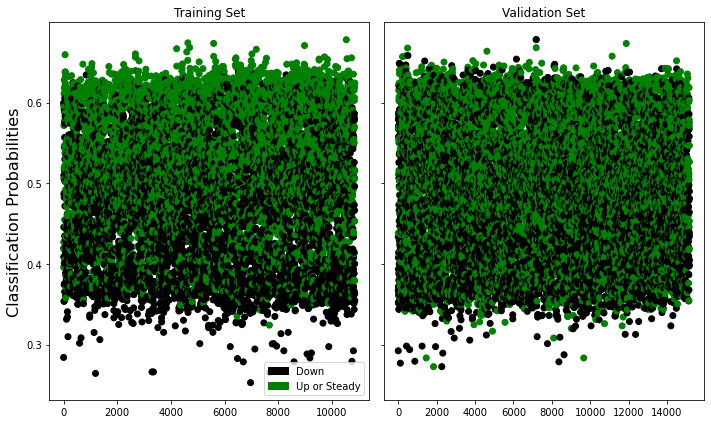

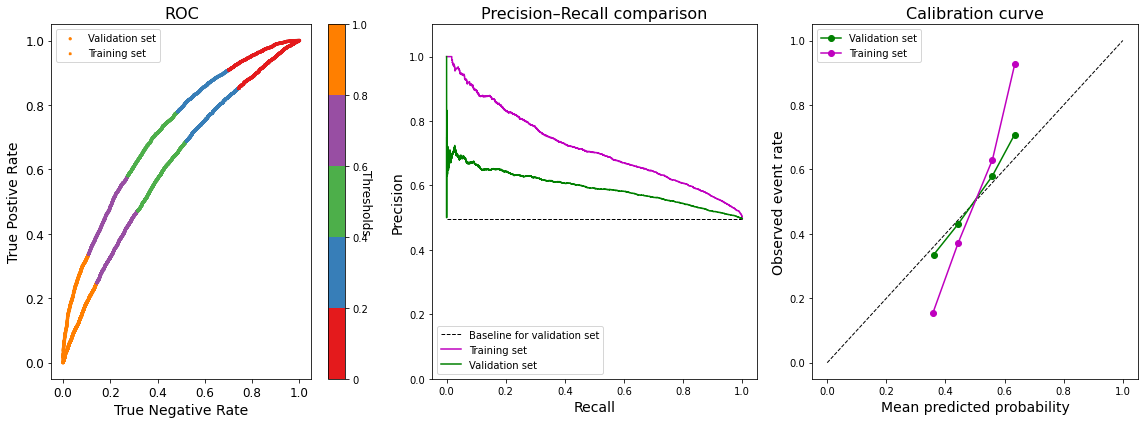

In [116]:
proba_valid_BT = BT.predict_proba(valid_X_clean)[:, 1]
proba_train_BT = BT.predict_proba(train_X_clean)[:, 1]

print("Training Set:")
print("AUC:", roc_auc_score(train_Y_binary, proba_train_BT))
print("LogLoss:", log_loss(train_Y_binary, proba_train_BT))
print("PR AUC:", average_precision_score(train_Y_binary, proba_train_BT))
print("Brier  :", brier_score_loss(train_Y_binary, proba_train_BT))
print("-----"*20)
print("Validation Set:")
print("AUC:", roc_auc_score(valid_Y_binary, proba_valid_BT))
print("LogLoss:", log_loss(valid_Y_binary, proba_valid_BT))
print("PR AUC:", average_precision_score(valid_Y_binary, proba_valid_BT))
print("Brier  :", brier_score_loss(valid_Y_binary, proba_valid_BT))
print("-----"*20)

# Classification Probabilities:
fig1, (axT,axV) = plt.subplots(1,2,figsize=(10,6), sharey=True)
fig2, (axROC,axPR,axC) = plt.subplots(1,3, figsize=(16,6))
valid_color = ['g' if y==1 else 'k' for y in valid_Y_binary]
axV.set_title("Validation Set",fontsize=12)
axV.scatter(range(len(proba_valid_BT)), proba_valid_BT, color=valid_color)

train_color = ['g' if y==1 else 'k' for y in train_Y_binary]
axT.set_ylabel("Classification Probabilities",fontsize=16)
axT.set_title("Training Set",fontsize=12)
axT.scatter(range(len(proba_train_BT)), proba_train_BT, color=train_color)

gr = mpatches.Patch(color='g', label='Up or Steady')
k = mpatches.Patch(color='k', label='Down')
axT.legend(handles=[k,gr])

# ROC:
fprV, tprV, threshV = roc_curve(valid_Y_binary,proba_valid_BT)
threshV[0] = 1
boundV = np.quantile(threshV, [0, .2, .4, .6, .8, 1.0])
norm = mcolors.BoundaryNorm(boundaries=boundV, ncolors=5, clip=True)
sc = axROC.scatter(fprV, tprV, c=threshV, cmap="Set1", norm=norm, s=5, marker='o', label='Validation set')
cb = plt.colorbar(sc, ax=axROC)
cb.set_label("Threshold bins")
cb.ax.set_yticklabels([0, .2, .4, .6, .8, 1.0])
cb.set_label('Thresholds', rotation=270,fontsize=12)

fprT, tprT, threshT = roc_curve(train_Y_binary,proba_train_BT)
threshT[0] = 1
boundT = np.quantile(threshV, [0, .2, .4, .6, .8, 1.0])
norm = mcolors.BoundaryNorm(boundaries=boundT, ncolors=5, clip=True)
sc = axROC.scatter(fprT, tprT, c=threshT, cmap="Set1", norm=norm, s=5, marker='x',label='Training set')

axROC.set_title("ROC",fontsize=16)
axROC.set_ylabel("True Postive Rate",fontsize=14)
axROC.set_xlabel("True Negative Rate",fontsize=14)
axROC.tick_params(axis='both', which='major', labelsize=12)
axROC.legend()

# Precision Recall Curve
precV, recV, thrV = precision_recall_curve(valid_Y_binary, proba_valid_BT)
precT, recT, thrT = precision_recall_curve(train_Y_binary, proba_train_BT)
pos_rate = (np.isclose(valid_Y_binary,1)).mean()
axPR.hlines(pos_rate, 0, 1, linestyles="--",color='k', linewidth=1, label="Baseline for validation set")
axPR.step(recT, precT, where="post", c='m', label='Training set')
axPR.step(recV, precV, where="post", c='g',label='Validation set')
axPR.set_xlabel("Recall",fontsize=14)
axPR.set_ylabel("Precision",fontsize=14)
axPR.set_title("Precision–Recall comparison",fontsize=16)
axPR.set_ylim((0,1.1))
axPR.legend(loc='lower left')

# Calibration Curve
prob_true, prob_pred = calibration_curve(valid_Y_binary, proba_valid_BT, n_bins=8)
prob_true_T, prob_pred_T = calibration_curve(train_Y_binary, proba_train_BT, n_bins=8)
axC.plot([0,1],[0,1],"--", lw=1,c='k')
axC.plot(prob_pred, prob_true, marker="o", c='g', label="Validation set")
axC.plot(prob_pred_T, prob_true_T, marker="o", c='m', label="Training set")
axC.set_xlabel("Mean predicted probability", fontsize=14)
axC.set_ylabel("Observed event rate", fontsize=14)
axC.set_title("Calibration curve", fontsize=16)
axC.legend()


fig1.tight_layout()
fig2.tight_layout()
plt.show()

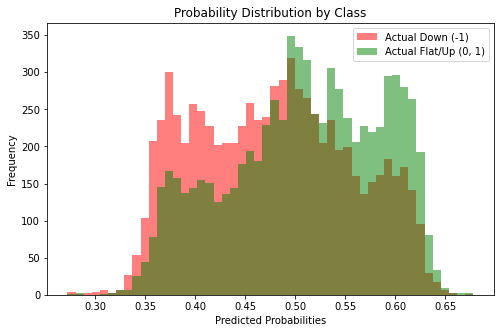

In [117]:
fig, ax = plt.subplots(figsize=(8, 5))

ax.hist(proba_valid_BT[valid_Y_binary == 0], bins=50, alpha=0.5, label='Actual Down (-1)', color='red')
ax.hist(proba_valid_BT[valid_Y_binary == 1], bins=50, alpha=0.5, label='Actual Flat/Up (0, 1)', color='green')

ax.set_title('Probability Distribution by Class')
ax.set_xlabel('Predicted Probabilities')
ax.set_ylabel('Frequency')
ax.legend()
plt.show()

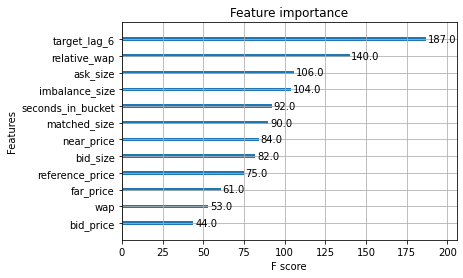

In [118]:
from xgboost import plot_importance

# 'weight' is the number of times a feature appears in a tree
plot_importance(BT, max_num_features=12, importance_type='weight')
plt.show()

In [119]:
booster = BT.get_booster()

# 2. Extract different importance types
# 'weight': number of times feature is used to split
# 'gain': average gain of splits which use the feature
# 'cover': average coverage of splits which use the feature
importance_types = ['weight', 'gain', 'cover']
importances = {t: booster.get_score(importance_type=t) for t in importance_types}

# 3. Create a clean DataFrame
importances_df = pd.DataFrame(importances).sort_values(by='gain', ascending=False)
print(importances_df)

                         weight       gain       cover
target_lag_6              187.0  23.797754  594.356262
relative_wap              140.0  12.064041  447.430786
seconds_in_bucket          92.0   7.513219  273.075775
wap                        53.0   7.369503  138.097153
ask_size                  106.0   6.867227  216.984940
bid_size                   82.0   5.900914  172.425247
near_price                 84.0   5.592308  163.042587
far_price                  61.0   5.388110  156.787018
ask_price                  39.0   5.369305  155.037567
matched_size               90.0   5.138919  179.075150
reference_price            75.0   5.132529  120.520432
imbalance_size            104.0   5.047821  163.246246
bid_price                  44.0   5.012719  132.304413
imbalance_buy_sell_flag    10.0   4.933575  128.752090


## up and down classification not looking too shabby, now let'a try predicting magnitude

In [120]:
divide = 200
train_data_X = x_wide_new_feats.loc[pdidx[divide:400, :], :].xs(STOCK, level=1, axis=1).reset_index().drop(columns=['date_id'])
train_data_Y = DY.loc[pdidx[divide:400, :],STOCK].values
valid_data_X = x_wide_new_feats.loc[pdidx[400:, :], :].xs(STOCK, level=1, axis=1).reset_index().drop(columns=['date_id'])
valid_data_Y = DY.loc[pdidx[400:, :],STOCK].values


## First, let's train and upwards/steady movement regressor

In [121]:
mask_train_up = (~np.isnan(train_data_Y)) & (train_data_Y >= 0)
train_Xup_clean = train_data_X[mask_train_up]
train_Y_up = train_data_Y[mask_train_up]

mask_valid_up = (~np.isnan(valid_data_Y)) & (valid_data_Y >= 0)
valid_Xup_clean = valid_data_X[mask_valid_up]
valid_Y_up = valid_data_Y[mask_valid_up]

### we'll also add classifier probabilities to help the regressor
Note: we train data points that the classifier was explicitly not trained on, this is important

In [122]:
train_probs = BT.predict_proba(train_Xup_clean)[:, 1]
valid_probs = BT.predict_proba(valid_Xup_clean)[:, 1]

s_train = pd.Series(train_probs, index=train_Xup_clean.index, name='clf_prob')
s_valid = pd.Series(valid_probs, index=valid_Xup_clean.index, name='clf_prob')

train_X_up = pd.concat([train_Xup_clean, s_train], axis=1)
valid_X_up = pd.concat([valid_Xup_clean, s_valid], axis=1)


### and, we'll scale the DY values in log to try and put the changes on equal footing

In [123]:
CONSTANT_BUMP = 10_000
eps = 1e-9
train_Y_up_log = np.log(CONSTANT_BUMP*train_Y_up + eps)
valid_Y_up_log = np.log(CONSTANT_BUMP*valid_Y_up + eps)

### we'll also scale the 'X_size' data with a log

In [87]:
def symlog(x):
#     if (x==0).any():
#         print('uhoh')
    return np.sign(x)*np.log(np.abs(x))

In [124]:
train_X_up['bid_size'] = np.log(train_X_up['bid_size'])
valid_X_up['bid_size'] = np.log(valid_X_up['bid_size'])

train_X_up['ask_size'] = np.log(train_X_up['ask_size'])
valid_X_up['ask_size'] = np.log(valid_X_up['ask_size'])

train_X_up['matched_size'] = np.log(train_X_up['matched_size'])
valid_X_up['matched_size'] = np.log(valid_X_up['matched_size'])

train_X_up['imbalance_size'] = np.log(train_X_up['imbalance_size'])
#replace bad values with 0
train_X_up['imbalance_size'] = train_X_up['imbalance_size'].replace([np.inf, -np.inf], np.nan).fillna(0)

valid_X_up['imbalance_size'] = np.log(valid_X_up['imbalance_size'])
#replace bad values with 0
valid_X_up['imbalance_size'] = valid_X_up['imbalance_size'].replace([np.inf, -np.inf], np.nan).fillna(0)

# train_X_up['bid_ask_lot_spread'] = symlog(train_X_up['bid_ask_lot_spread'])
# valid_X_up['bid_ask_lot_spread'] = symlog(valid_X_up['bid_ask_lot_spread'])


divide by zero encountered in log


### Let's try another feature.. bid-ask-spread


In [125]:
BAspread_train = pd.Series(train_X_up['bid_size'] - train_X_up['ask_size'], index=train_X_up.index, name='bid_ask_lot_spread')
BAspread_valid = pd.Series(valid_X_up['bid_size'] - valid_X_up['ask_size'], index=valid_X_up.index, name='bid_ask_lot_spread')

train_X_up = pd.concat([train_X_up, BAspread_train], axis=1)
valid_X_up = pd.concat([valid_X_up, BAspread_valid], axis=1)


## Model:

In [126]:
RT_up = XGBRegressor(
    n_estimators=1_000,
    learning_rate=0.005,           # Ultra-slow to prevent the error jump
    max_depth=3,                   # Very shallow
    min_child_weight=100,          # Only learn very broad, obvious patterns
    objective='reg:squarederror',
    eval_metric='mae',
    base_score=0.0,
    tree_method='hist',
    early_stopping_rounds=50,
)

In [127]:
RT_up.fit(
    train_X_up, 
    train_Y_up_log,
    eval_set=[(valid_X_up, valid_Y_up_log)],
    verbose=200
)

[0]	validation_0-mae:9.96158
[200]	validation_0-mae:3.73712
[400]	validation_0-mae:1.64518
[600]	validation_0-mae:1.09637
[800]	validation_0-mae:0.97881
[999]	validation_0-mae:0.94845


XGBRegressor(base_score=0.0, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric='mae', feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.005, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=100, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

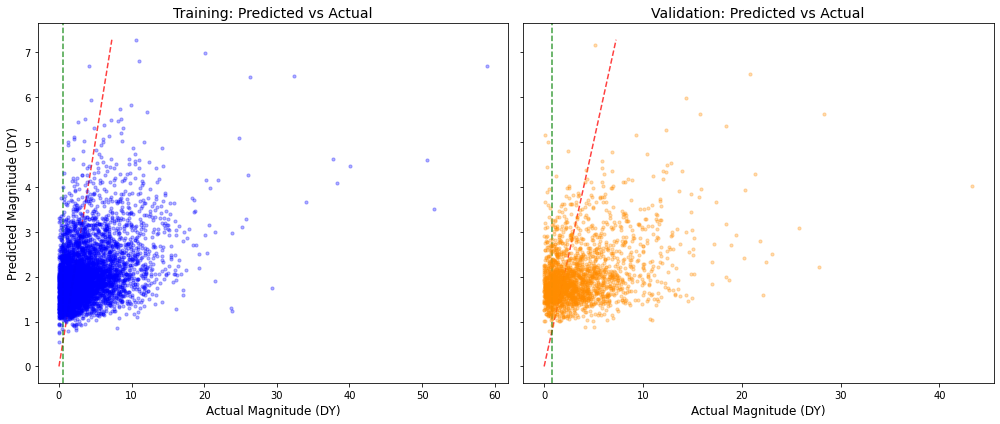

In [128]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
preds_train = (np.exp(RT_up.predict(train_X_up)) - eps)/CONSTANT_BUMP
preds_valid = (np.exp(RT_up.predict(valid_X_up)) - eps)/CONSTANT_BUMP
# --- Training Set Plot ---
ax1.scatter(train_Y_up, preds_train, alpha=0.3, color='blue', s=10)
# Add the 'Perfect Prediction' line
# lims = [0, max(train_Y_up.max(), preds_train.max())]
lims = [0, preds_train.max()]
ax1.plot(lims, lims, 'r--', alpha=0.75, zorder=0)
ax1.axvline(x=preds_train.min(),linestyle='--',c='g',alpha=0.75,zorder=0)
ax1.set_title("Training: Predicted vs Actual", fontsize=14)
ax1.set_xlabel("Actual Magnitude (DY)", fontsize=12)
ax1.set_ylabel("Predicted Magnitude (DY)", fontsize=12)

# --- Validation Set Plot ---
ax2.scatter(valid_Y_up, preds_valid, alpha=0.3, color='darkorange', s=10)
ax2.plot(lims, lims, 'r--', alpha=0.75, zorder=0)
ax2.axvline(x=preds_valid.min(),linestyle='--',c='g',alpha=0.75,zorder=0)
ax2.set_title("Validation: Predicted vs Actual", fontsize=14)
ax2.set_xlabel("Actual Magnitude (DY)", fontsize=12)

plt.tight_layout()

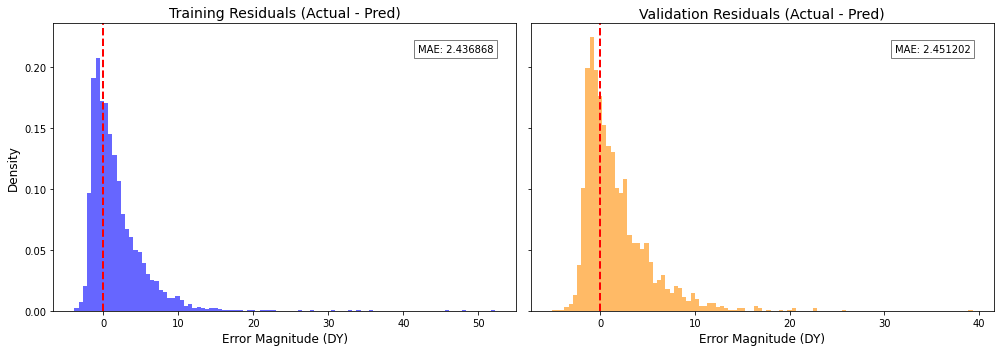

In [129]:
# 1. Calculate the Residuals (Truth - Prediction)
# Positive = Under-predicting | Negative = Over-predicting
resid_train = train_Y_up - preds_train
resid_valid = valid_Y_up - preds_valid

fig, (axH1, axH2) = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

# --- Training Residuals ---
axH1.hist(resid_train, bins=100, color='blue', alpha=0.6, density=True)
axH1.axvline(0, color='red', linestyle='--', lw=2)
axH1.set_title("Training Residuals (Actual - Pred)", fontsize=14)
axH1.set_xlabel("Error Magnitude (DY)", fontsize=12)
axH1.set_ylabel("Density", fontsize=12)

# --- Validation Residuals ---
axH2.hist(resid_valid, bins=100, color='darkorange', alpha=0.6, density=True)
axH2.axvline(0, color='red', linestyle='--', lw=2)
axH2.set_title("Validation Residuals (Actual - Pred)", fontsize=14)
axH2.set_xlabel("Error Magnitude (DY)", fontsize=12)

# Optional: Add a text box with Mean Absolute Error (MAE)
train_mae = np.mean(np.abs(resid_train))
valid_mae = np.mean(np.abs(resid_valid))
axH1.text(0.95, 0.90, f'MAE: {train_mae:.6f}', transform=axH1.transAxes, ha='right', bbox=dict(facecolor='white', alpha=0.5))
axH2.text(0.95, 0.90, f'MAE: {valid_mae:.6f}', transform=axH2.transAxes, ha='right', bbox=dict(facecolor='white', alpha=0.5))

plt.tight_layout()
plt.show()

In [130]:
# importance_type = 'gain' # Can also be 'weight' or 'cover'
# scores = RT_up.get_booster().get_score(importance_type=importance_type)

# # Sort and Plot
# sorted_scores = dict(sorted(scores.items(), key=lambda item: item[1], reverse=True))

# plt.figure(figsize=(10, 8))
# plt.barh(list(sorted_scores.keys())[:15], list(sorted_scores.values())[:15])
# plt.xlabel(f"XGBoost {importance_type.capitalize()}")
# plt.title(f"Top 15 Features by {importance_type.capitalize()}")
# plt.gca().invert_yaxis()
# plt.show()
booster = RT_up.get_booster()

# 2. Extract different importance types
# 'weight': number of times feature is used to split
# 'gain': average gain of splits which use the feature
# 'cover': average coverage of splits which use the feature
importance_types = ['weight', 'gain', 'cover']
importances = {t: booster.get_score(importance_type=t) for t in importance_types}

# 3. Create a clean DataFrame
importances_df = pd.DataFrame(importances).sort_values(by='gain', ascending=False)
print(importances_df)

                         weight       gain        cover
ask_size                  404.0  25.039032  2449.878662
target_lag_6              755.0  22.819244  3552.507324
clf_prob                   59.0  19.097605  1669.508423
seconds_in_bucket        1249.0  18.886877  3049.522705
ask_price                  67.0  17.781698  2235.283691
bid_ask_lot_spread        116.0  15.424371  4746.810547
bid_size                  486.0  14.256811  3279.911621
near_price                116.0  13.957173  1836.827637
matched_size              463.0  13.950837  4265.418945
wap                        59.0  13.823471  4419.338867
imbalance_size            379.0  13.650971  2972.965820
bid_price                 254.0  13.339348  4744.322754
relative_wap              190.0  12.854344  2600.768311
reference_price            58.0  10.938256  1199.051758
far_price                  85.0  10.848460  1752.482300
imbalance_buy_sell_flag    26.0   9.857077   282.000000


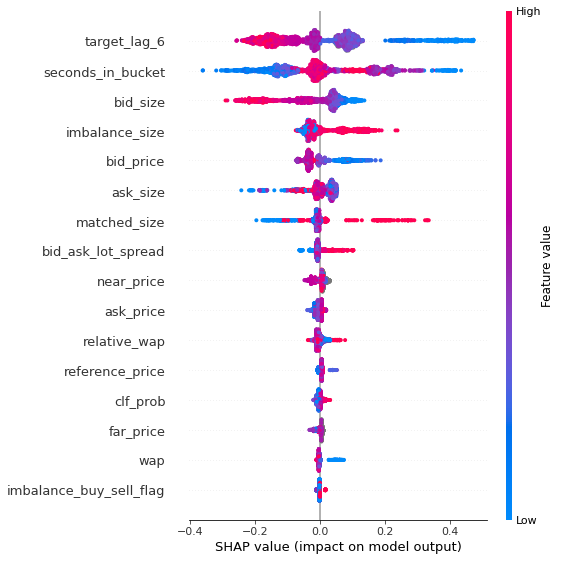

In [131]:
import shap

# Initialize the explainer
explainer = shap.TreeExplainer(RT_up)
shap_values = explainer.shap_values(valid_X_up)

# Summary plot
shap.summary_plot(shap_values, valid_X_up)

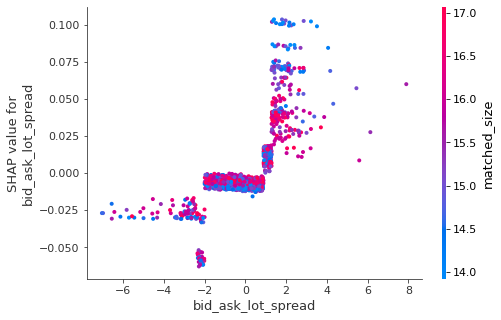

In [132]:
shap.dependence_plot("bid_ask_lot_spread", shap_values, valid_X_up)

# Older Stuff

In [ ]:
id_and_wap = pd.read_csv('../train.csv',delimiter=',',usecols=['stock_id','seconds_in_bucket','wap','date_id'])

In [ ]:
my_Sid = 100
my_Did = 100

In [ ]:
# my_stock = id_and_wap[np.bitwise_and(id_and_wap['stock_id']==my_Sid, id_and_wap['date_id']==my_Did)]
my_stock = id_and_wap[id_and_wap['stock_id']==my_Sid]
time = my_stock['seconds_in_bucket']
print(time.size//481)
time = time.values.reshape(481,time.size//481)
wap = my_stock['wap'].values.reshape(481,time.size//481)

In [ ]:
my_stock

In [ ]:
concat_time = time[0]
concat_wap = wap[0]
prevT = concat_time[-1]
for t,w in zip(time[1:],wap[1:]):
    newT = t+prevT
    concat_time = np.append(concat_time,newT)
    concat_wap = np.append(concat_wap,w)
    prevT = concat_time[-1]
plt.plot(concat_time,concat_wap)

# Let's already try some TDA!

## for a baseline, let's look at some Black-Scholes time series and then maybe some Heston or Heston-Nandi

## Black-Scholes (log returns):

In [ ]:
def stock_path_BS(S0, t, r, mu, sigma, n_paths, n_steps, log=False):
    '''
    Generation of stock paths following Geometeric Brownian motion
    
    Inputs:
    S0 (float): initial stock value
    t (float): time interval of stock path movements in years
    r (float): risk-free interest rate
    mu (float): drift of log-returns
    sigma (float): volatility
    n_paths (int): number of stock paths
    n_steps (float): number of steps in each stock path
    
    Returns:
    
    Simulated stock paths
    '''
    
    #Noise in volatility
    noise = np.random.normal(0,1,size = (n_paths, n_steps-1))
        
    #Time increment between each step, needs to match proper shape
    dt = t/n_steps
    
    #log-returns between each step
    increments = (mu + r - .5*sigma**2)*dt + sigma*np.sqrt(dt)*noise
    
    #Cumulative log-returns at each step
    log_returns = np.cumsum(increments, axis = 1)
    
    #paths
    paths = S0*np.exp(log_returns) if not log else log_returns
    
    #Adjoint initial value S0 at start of each simulated path
    if not log:
        paths = np.insert(paths, 0, S0, axis = 1)
    else:
    #S0 = 1 for log return paths
        paths = np.insert(paths, 0, 1, axis = 1)
    
    
    return paths

Let's construct something close to 30 point clouds in 3 dimensions with 100 points, so we can follow allowing with the giotto tutorial. However, we will not construct a random point cloud, but instead construct those paramters with 3 PATHS, AND 990 TIME STEPS. This will allow us to bin it into 30 point clouds of 99 points each

In [ ]:
#S0 is meaningless for log returns
Npaths = 3
clouds = 10
points_per_cloud_per_path = 100

ALL_PATHS = stock_path_BS(100, 10, 0.01, 0.02, 0.3, Npaths, clouds*points_per_cloud_per_path,log=True)
analyze_differences = True
if analyze_differences:
    for i in range(ALL_PATHS.shape[0]):
        ALL_PATHS[i][0] = 0
        ALL_PATHS[i][1:] = ALL_PATHS[i][1:] - ALL_PATHS[i][:-1]

#Create 30 point cloud batches
BS_point_clouds = np.reshape(ALL_PATHS,(Npaths,clouds,points_per_cloud_per_path))
BS_point_clouds = BS_point_clouds.transpose(1,2,0)

In [ ]:
print(BS_point_clouds.shape)

In [ ]:
i=0
for j in range(Npaths):
    plt.plot(range(points_per_cloud_per_path),BS_point_clouds[i,:,j])
plt.show()

In [ ]:
BS_point_clouds[9].shape

In [ ]:
plot_point_cloud(BS_point_clouds[0])

In [ ]:
from gtda.homology import VietorisRipsPersistence

VR = VietorisRipsPersistence(homology_dimensions=[0, 1, 2])
diagrams_BS = VR.fit_transform(BS_point_clouds)
diagrams_BS.shape

In [ ]:
from gtda.plotting import plot_diagram

i = 5
plot_diagram(diagrams_BS[i])

# Heston-Nandi Garch 1-1

In [ ]:
def stock_path_heston_nandi(S0, h0, t, mu, r, Var_mean, beta, alpha, gamma, n_paths, n_steps,scale=1, lam=-1/2,
                           log=False):
    '''
    Generation of custom stock paths following Heston-Nandi Garch (1,1) 
    
    ((  Heston, Steven L. and Nandi, Saikat, A Closed-Form GARCH Option Valuation Model.
    Available at SSRN: https://ssrn.com/abstract=210009 or http://dx.doi.org/10.2139/ssrn.210009  ))
    
    This is a GARCH(1,1) process, where the mean (Stock price) dynamics are given by something
    structurally similar to Black-Scholes model, Heston model, etc
    
    Inputs: (loosley following notation from paper)
    -S0 (float): inital stock value
    -h0 (float): initial variance
    -mu (float): drift of log returns
    -r (float): risk free rate
    - Var_mean (float): Mean of variance, used to calulate omega, the GARCH parameter
    -beta (float): GARCH mean reversion parameter for variance
    -alpha (float): GARCH error influence parameter (moving average) for variance
    -lam (float): lambda in the Heston-Nandi paper, "market price of risk", set to -1/2 for risk neutral
    -gamma (float): "asymmetric influence", extra GARCH parameter which influeces moving average for variance
    
    - S_mean (float): Mean of stock price, used to calculate mu, the ARMA parameter
    - Var_mean (float): Mean of variance, used to calulate omega, the GARCH parameter
    
    -n_paths (int): number of stock paths
    -n_steps (float): number of steps in each stock path
    
    scale (int): an intraday scale that helps reduce flatness of S_T, can be seen as reducing dt

    Returns:
    
    Simulated stock paths
    Simulated volatility paths
    '''
    
    n_steps = n_steps*scale - 1
    #GARCH parameters also need to be rescaled
    alpha /= scale
    beta /= scale
    
    #converting from mean varaince to haston-nandi GARCH omega
    omega = Var_mean*(1 - beta - alpha*(1 + gamma*gamma))
    
    #following notation of the paper, z is the noise at time t
    z = np.random.normal(0,1,size = (n_paths,n_steps))

    #set arrays
    h_T = np.zeros((n_paths, n_steps+1))
    S_T = np.zeros((n_paths, n_steps+1))
    h_T[:,0] = h0
    S_T[:,0] = S0 if not log else 0
    
    dt = t/n_steps
    if not log:
        for i in range(n_steps):
            h_prev, S_prev = h_T[:,i], S_T[:,i]

            h_T[:,i+1] = omega + beta*h_prev + alpha*(z[:,i] - gamma*np.sqrt(h_prev))**2
            var_T = h_T[:,i+1]
            #KEY DIFFERENCE BETWEEN THIS AND HESTON: S-T CALCULATED FROM **CURRENT** VOLATILITY
            S_T[:,i+1] = S_prev*np.exp((mu + r - lam*var_T)*dt + np.sqrt(var_T*dt)*z[:,i])
    else:
        for i in range(n_steps):
            h_prev, S_prev = h_T[:,i], S_T[:,i]

            h_T[:,i+1] = omega + beta*h_prev + alpha*(z[:,i] - gamma*np.sqrt(h_prev))**2
            var_T = h_T[:,i+1]
            #KEY DIFFERENCE BETWEEN THIS AND HESTON: S_T CALCULATED FROM **CURRENT** VOLATILITY
            S_T[:,i+1] = (mu + r - lam*var_T)*dt + np.sqrt(var_T*dt)*z[:,i]    
        
    return S_T[:,::scale], h_T[:,::scale]

In [ ]:
S0 = 100
t = 1
r = 0.039
mu = 0
h0 = 0.3
Var_mean = 0.3
beta = 0.1
alpha = 0.1
gamma = 0.1

Npaths = 30
clouds = 30
points_per_cloud_per_path = 5
scale = 1

S_T, nu_T = stock_path_heston_nandi(S0, h0, t, mu, r, Var_mean, beta, alpha, gamma, Npaths,\
                                    points_per_cloud_per_path*clouds, scale,log=True)

In [ ]:
analyze_differences = True
if analyze_differences:
    for i in range(S_T.shape[0]):
        S_T[i][0] = 0
        S_T[i][1:] = S_T[i][1:] - S_T[i][:-1]
        
#Create 30 point cloud batches
HN_point_clouds = np.reshape(S_T,(Npaths,clouds,points_per_cloud_per_path))
HN_point_clouds = HN_point_clouds.transpose(1,2,0)

In [ ]:
i=20
for j in range(Npaths):
    plt.plot(range(points_per_cloud_per_path),HN_point_clouds[i,:,j])
plt.show()

In [ ]:
HN_point_clouds[10].shape

In [ ]:
plot_point_cloud(HN_point_clouds[10])

In [ ]:
VR = VietorisRipsPersistence(homology_dimensions=[0, 1, 2])
diagrams_HN = VR.fit_transform(HN_point_clouds)
diagrams_HN.shape

In [ ]:
plot_diagram(diagrams_HN[10])

In [ ]:
from gtda.time_series import PearsonDissimilarity
from gtda.diagrams import Amplitude
PD = PearsonDissimilarity()

X_pd = PD.fit_transform(HN_point_clouds)
VR = VietorisRipsPersistence(metric="precomputed",homology_dimensions=[0, 1, 2])
X_vr = VR.fit_transform(X_pd)  # "precomputed" required on dissimilarity data
Ampl = Amplitude()
X_a = Ampl.fit_transform(X_vr)
X_a

# Let's try  on teh data?!

In [ ]:
# instead of this, let's try on one stock at a time
# let's analyze changes instead of raw values (since we don't know the scale anyway)
# finally, let's decide on some window length, i guess one window per day (54 points per window per stock)
# will do for now, and if it's too small, we can try including multiple days into a window

In [ ]:
id_and_wap = pd.read_csv('../train.csv',delimiter=',',usecols=['stock_id','date_id','seconds_in_bucket','wap'])

In [ ]:
# my_stock = id_and_wap[np.bitwise_and(id_and_wap['stock_id']==my_Sid, id_and_wap['date_id']==my_Did)]
my_stock = id_and_wap[id_and_wap['stock_id']==100].drop(columns='stock_id')
# time = my_stock['seconds_in_bucket'].values.reshape(481,time.size//481)
# wap = my_stock['wap'].values.reshape(481,time.size//481)

In [ ]:
my_stock

In [ ]:
waps = my_stock.drop(columns=['date_id','seconds_in_bucket']).values.reshape(481,55)
waps = waps.transpose()
print(waps.shape)
# waps = waps[30:]
# print(waps.shape)

In [ ]:
analyze_differences = True
if analyze_differences:
    for i in range(waps.shape[0]):
        waps[i][0] = 0
        waps[i][1:] = waps[i][1:] - waps[i][:-1]
        
#Create 30 point cloud batches
stock_100_test_cloud = np.reshape(waps,(55,13,37))
stock_100_test_cloud = stock_100_test_cloud.transpose(1,2,0)

In [ ]:
i=2
for j in range(55):
    plt.plot(range(37),stock_100_test_cloud[i,:,j])
plt.show()

In [ ]:
stock_100_test_cloud[2].shape

In [ ]:
plot_point_cloud(stock_100_test_cloud[10])

In [ ]:
VR = VietorisRipsPersistence(homology_dimensions=[0, 1, 2])
diagrams_test = VR.fit_transform(stock_100_test_cloud)
diagrams_test.shape

In [ ]:
plot_diagram(diagrams_test[10])

In [ ]:
from gtda.time_series import PearsonDissimilarity
from gtda.diagrams import Amplitude
PD = PearsonDissimilarity()

X_pd = PD.fit_transform(stock_100_test_cloud)
VR = VietorisRipsPersistence(metric="precomputed",homology_dimensions=[0, 1, 2])
X_vr = VR.fit_transform(X_pd)  # "precomputed" required on dissimilarity data
Ampl = Amplitude()
X_a = Ampl.fit_transform(X_vr)
X_a

# Delay embedding?

In [ ]:
from gtda.time_series import SingleTakensEmbedding


# on trial data

### Black Scholes

In [ ]:
dimension_BS = 5
delay_BS = 2
stride = 1

embedder_BS = SingleTakensEmbedding(
    parameters_type="fixed",
    n_jobs=1,
    time_delay=delay_BS,
    dimension=dimension_BS,
    stride=stride,
)


In [ ]:
#S0 is meaningless for log returns
Npaths = 1
clouds = 1
points_per_cloud_per_path = 100

data_BS = stock_path_BS(100, 10, 0.01, 0.02, 0.3, Npaths, clouds*points_per_cloud_per_path,log=True)
analyze_differences = True
if analyze_differences:
    for i in range(ALL_PATHS.shape[0]):
        ALL_PATHS[i][0] = 0
        ALL_PATHS[i][1:] = ALL_PATHS[i][1:] - ALL_PATHS[i][:-1]
        
#Create 30 point cloud batches
# BS_point_clouds = np.reshape(ALL_PATHS,(Npaths,clouds,points_per_cloud_per_path))
# BS_point_clouds = BS_point_clouds.transpose(1,2,0)
# BS_point_clouds = BS_point_clouds[:,:,0]
embedded_BS = embedder_BS.fit_transform(data_BS[0])
print(f"Shape of embedded time series: {embedded_BS.shape}")

In [ ]:
plot_point_cloud(embedded_BS)

In [ ]:
VR = VietorisRipsPersistence(homology_dimensions=[0, 1, 2])
diagrams_test_delay = VR.fit_transform([embedded_BS])
diagrams_test_delay.shape
plot_diagram(diagrams_test_delay[0])

### Heston-Nandi

# on the data

In [ ]:

embedding_dimension_periodic = 5
embedding_time_delay_periodic = 2
stride = 1

embedder_periodic = SingleTakensEmbedding(
    parameters_type="fixed",
    n_jobs=1,
    time_delay=embedding_time_delay_periodic,
    dimension=embedding_dimension_periodic,
    stride=stride,
)

#upper bounds for search
# time_delay=5
# embedding_dimension=10

# embedder_periodic = SingleTakensEmbedding(
#     parameters_type="search", time_delay=time_delay, dimension=embedding_dimension,
# )

In [ ]:
waps = my_stock.drop(columns=['date_id','seconds_in_bucket']).values.reshape(481,55)
data = waps[10]
analyze_differences = False
if analyze_differences:
    data = data[1:]-data[:-1]

embedded = embedder_periodic.fit_transform(data)
print(f"Shape of embedded time series: {embedded.shape}")

In [ ]:
plot_point_cloud(embedded)

In [ ]:
VR = VietorisRipsPersistence(homology_dimensions=[0, 1, 2])
diagrams_test_delay = VR.fit_transform([embedded])
diagrams_test_delay.shape

In [ ]:
plot_diagram(diagrams_test_delay[0])

# imbalance size?

In [ ]:
id_and_wap = pd.read_csv('../train.csv',delimiter=',',usecols=['stock_id','date_id','seconds_in_bucket','imbalance_size'])
my_stock_IB = id_and_wap[id_and_wap['stock_id']==100].drop(columns='stock_id')


In [ ]:
IBs = my_stock_IB.drop(columns=['date_id','seconds_in_bucket']).values.reshape(481,55)
data = IBs[10]

embedding_dimension_periodic = 3
embedding_time_delay_periodic = 1
stride = 1

embedder_periodic = SingleTakensEmbedding(
    parameters_type="fixed",
    n_jobs=1,
    time_delay=embedding_time_delay_periodic,
    dimension=embedding_dimension_periodic,
    stride=stride,
)
embedded = embedder_periodic.fit_transform(data)
print(f"Shape of embedded time series: {embedded.shape}")

In [ ]:
plt.plot(range(data.size),data)

In [ ]:
plot_point_cloud(embedded)

In [ ]:
VR = VietorisRipsPersistence(homology_dimensions=[0, 1, 2])
diagrams_test_delay = VR.fit_transform([embedded])
diagrams_test_delay.shape

In [ ]:
plot_diagram(diagrams_test_delay[0])